In [1]:
import numpy as np
import os
import sys
from gensim.models import KeyedVectors
from sklearn.metrics import RocCurveDisplay, classification_report
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('')), 'scripts'))
from past_present_train_test_split import prepare_training_data
from CitationRateEncoder import CitationRateEncoder

In [2]:
np.random.seed(10)

In [3]:
G, df, (train, test) = prepare_training_data()
df = df.drop(columns=['Date', 'Title', 'Authors', 'Abstract'])
df.head()

Papers after date found by split : 20206


,Paper_ID,target_citation_rate
0,9511170,0.0
1,9211024,0.0
2,9806180,9.0
5,9503176,3.0
6,9611143,0.0


In [4]:
embs_path = os.path.join(os.pardir, 'n2c_embs')
node_embeddings = KeyedVectors.load_word2vec_format(embs_path)

In [5]:
df['embeddings'] = df['Paper_ID'].apply(lambda x: node_embeddings[str(x)])
df.head()

,Paper_ID,target_citation_rate,embeddings
0,9511170,0.0,"[0.2766353, 0.29462746, -0.09656201, -0.050717..."
1,9211024,0.0,"[0.1981441, 0.20687786, 0.007860992, -0.068715..."
2,9806180,9.0,"[0.21878144, 0.4326537, -0.41083947, -0.028274..."
5,9503176,3.0,"[0.26588473, 0.080661766, -0.008371197, -0.081..."
6,9611143,0.0,"[0.4128731, 0.13393031, 0.13527784, -0.1239899..."


In [6]:
encoder = CitationRateEncoder(4)
encoder.fit(G)

<Axes: >

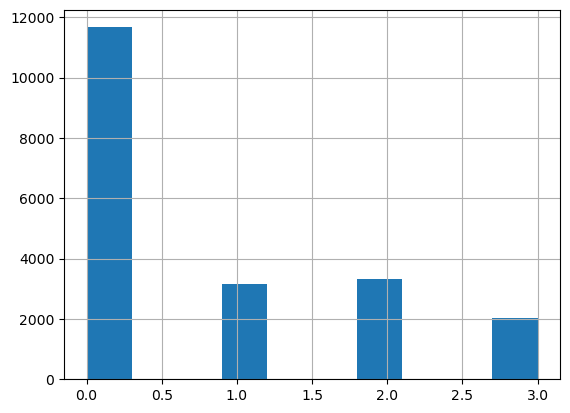

In [7]:
df['target'] = encoder.transform(df['target_citation_rate'])
df['target'].hist()

In [8]:
def crop_data(df):
    mn = df[df['Paper_ID'].isin(train)]['target'].value_counts().min()
    for target in df['target'].unique():
        condition = (df['target'] == target) & (df['Paper_ID'].isin(train))
        to_drop = len(df[condition]) - mn
        ids_to_drop = df[condition].sample(n=to_drop).index
        df.drop(ids_to_drop, inplace=True)

<Axes: >

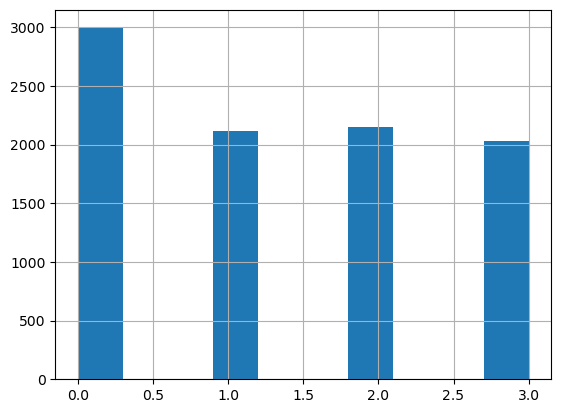

In [9]:
crop_data(df)
df['target'].hist()

In [10]:
X_train = np.array([np.array(x) for x in df[df['Paper_ID'].isin(train)]['embeddings']])
y_train = df[df['Paper_ID'].isin(train)]['target']

X_test = np.array([np.array(x) for x in df[df['Paper_ID'].isin(test)]['embeddings']])
y_test = df[df['Paper_ID'].isin(test)]['target']

<Axes: >

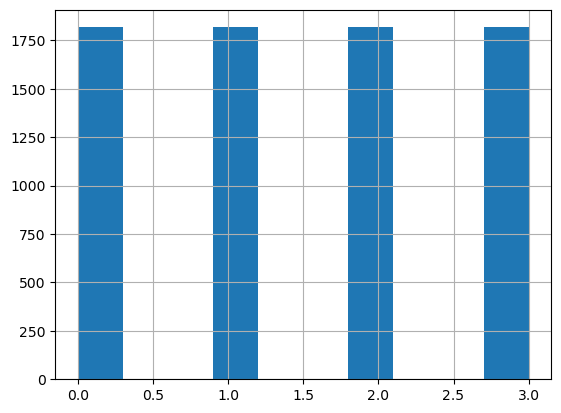

In [11]:
y_train.hist()

<Axes: >

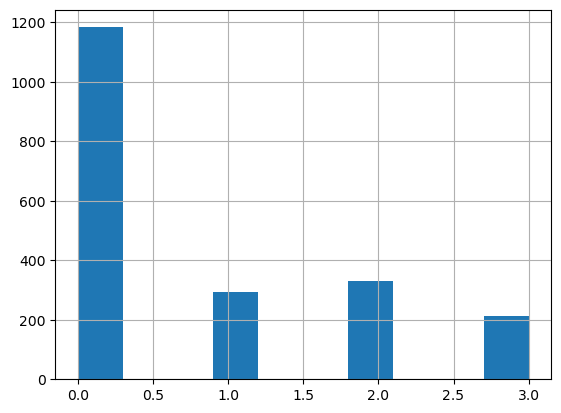

In [12]:
y_test.hist()

In [13]:
from sklearn.linear_model import LogisticRegression

node_classifier = LogisticRegression(random_state=10, verbose=1, solver='sag')
node_classifier.fit(X_train, y_train)

Epoch 1, change: 1.00000000
Epoch 2, change: 0.42945695
Epoch 3, change: 0.42329580
Epoch 4, change: 0.27417648
Epoch 5, change: 0.18476534
Epoch 6, change: 0.13389009
Epoch 7, change: 0.07126272
Epoch 8, change: 0.06248302
Epoch 9, change: 0.05817198
Epoch 10, change: 0.03939604
Epoch 11, change: 0.03052330
Epoch 12, change: 0.02449621
Epoch 13, change: 0.02290548
Epoch 14, change: 0.01203838
Epoch 15, change: 0.00991694
Epoch 16, change: 0.00998923
Epoch 17, change: 0.00545410
Epoch 18, change: 0.00426875
Epoch 19, change: 0.00293519
Epoch 20, change: 0.00272426
Epoch 21, change: 0.00317827
Epoch 22, change: 0.00172956
Epoch 23, change: 0.00133382
Epoch 24, change: 0.00119351
Epoch 25, change: 0.00080327
Epoch 26, change: 0.00057394
Epoch 27, change: 0.00043394
Epoch 28, change: 0.00043162
Epoch 29, change: 0.00025646
Epoch 30, change: 0.00018106
Epoch 31, change: 0.00012467
Epoch 32, change: 0.00013398
convergence after 33 epochs took 1 seconds


LogisticRegression(random_state=10, solver='sag', verbose=1)

In [14]:
if len(node_classifier.classes_) == 2:
    val_preds = node_classifier.predict_proba(X_test)[:, 1]
    RocCurveDisplay.from_predictions(y_test, val_preds)
    val_preds = (val_preds >= 0.5)
else:
    val_preds = node_classifier.predict(X_test)

In [15]:
print(classification_report(y_test, val_preds))

              precision    recall  f1-score   support

           0       0.77      0.69      0.73      1183
           1       0.18      0.19      0.18       295
           2       0.25      0.23      0.24       331
           3       0.37      0.61      0.46       212

    accuracy                           0.53      2021
   macro avg       0.39      0.43      0.40      2021
weighted avg       0.55      0.53      0.54      2021

